In [1]:
!pip install opencv-python
!pip install opencv-python-headless

     |████████████████████████████████| 60.9 MB 19.5 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
     |████████████████████████████████| 48.3 MB 18.6 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
pip install -U scikit-image

     |████████████████████████████████| 12.4 MB 19.6 MB/s eta 0:00:01
     |████████████████████████████████| 148 kB 90.2 MB/s eta 0:00:01
     |████████████████████████████████| 4.4 MB 82.1 MB/s eta 0:00:01
     |████████████████████████████████| 1.6 MB 73.1 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import scipy

In [4]:
import tensorflow as tf
from keras.applications.vgg16 import VGG16 as vgg16
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2 as mobilenetv2
from tensorflow.keras.applications.resnet50 import ResNet50 as resnet50
from tensorflow.keras.applications.inception_v3 import InceptionV3 as inception
from tensorflow.keras.applications.densenet import DenseNet169 as densenet
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import Model
from keras import layers, Sequential
from matplotlib import pyplot
from math import floor
import numpy as np
import cv2
from os import listdir
from os.path import isfile, join
from numpy import expand_dims, array, exp, max
import json
import skimage.feature as feature
from skimage.io import imread
from skimage.color import rgb2gray

from skimage.transform import resize

In [15]:
model1 = inception()
model2 = Model(inputs=model1.inputs, outputs=model1.layers[1].output)
# model.add(layers.MaxPool2D(pool_size=(2, 2),strides=(1, 1), padding='valid'))
model = Sequential(layers=model2.layers)
model.add(layers.MaxPool2D(pool_size=(3, 3), strides=(3, 3), padding='same'))
# model = Model(inputs=model.inputs, outputs = model.layers[1].output)

model.summary()

96116736/96112376 [==============================] - 1s 0us/step
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 149, 149, 32)      864       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 50, 50, 32)        0         
Total params: 864
Trainable params: 864
Non-trainable params: 0
_________________________________________________________________


In [16]:
class LocalBinaryPatterns:
  def __init__(self, numPoints, radius):
    self.numPoints = numPoints
    self.radius = radius

  def describe(self, image, eps = 1e-7):
    lbp = feature.local_binary_pattern(image, self.numPoints, self.radius, method="uniform")
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, self.numPoints+3), range=(0, self.numPoints + 2))

    # Normalize the histogram
    hist = hist.astype('float')
    hist /= (hist.sum() + eps)

    return hist, lbp

In [17]:
###########################THIS CODE CHECKS IMAGES FROM A FOLDER#################################

def sortTrainImages():
    # get the class labels from training datasets
    p = {}
    data_path = '../../../paper3/StanfordDogs/Stanford_Dogs'
    img_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1. / 255, rotation_range=20)
    #labels = img_gen.flow_from_directory(data_path + '/Images')
    #train_labels = labels.class_indices.keys()

    #for lbl in train_labels:
    resnet_path = data_path +'/Images/' + 'n02089973-English_foxhound'
    p_files = [f for f in listdir(resnet_path) if isfile(join(resnet_path, f))]
    pests_images = np.empty(len(p_files), dtype=object)
    print(p_files)
    for m in range(0, len(p_files)):
        
            #print(join(resnet_path, p_files[m]))
        imageName_x = p_files[m]
        p.update({'n02089973-English_foxhound' + "_" + str(m): imageName_x})
            ######if m < 25:
                #pests_images[m] = cv2.imread(join(resnet_path, p_files[m]))
                # get the name of the image
                ######imageName_x = p_files[m]
                #####p.update({lbl + "_" + str(m): imageName_x})

    return p


images_collection = sortTrainImages()

['n02089973_3156.jpg', 'n02089973_3159.jpg', 'n02089973_1352.jpg', 'n02089973_1232.jpg', 'n02089973_3265.jpg', 'n02089973_32.jpg', 'n02089973_3480.jpg', 'n02089973_437.jpg', 'n02089973_3119.jpg', 'n02089973_1324.jpg', 'n02089973_1877.jpg', 'n02089973_2781.jpg', 'n02089973_2300.jpg', 'n02089973_2045.jpg', 'n02089973_1623.jpg', 'n02089973_2603.jpg', 'n02089973_2.jpg', 'n02089973_957.jpg', 'n02089973_981.jpg', 'n02089973_2681.jpg', 'n02089973_770.jpg', 'n02089973_1690.jpg', 'n02089973_2509.jpg', 'n02089973_2476.jpg', 'n02089973_1260.jpg', 'n02089973_3401.jpg', 'n02089973_1345.jpg', 'n02089973_2181.jpg', 'n02089973_382.jpg', 'n02089973_1907.jpg', 'n02089973_1277.jpg', 'n02089973_4307.jpg', 'n02089973_2551.jpg', 'n02089973_3651.jpg', 'n02089973_1078.jpg', 'n02089973_2599.jpg', 'n02089973_1255.jpg', 'n02089973_569.jpg', 'n02089973_1803.jpg', 'n02089973_2500.jpg', 'n02089973_1381.jpg', 'n02089973_417.jpg', 'n02089973_2093.jpg', 'n02089973_3323.jpg', 'n02089973_1357.jpg', 'n02089973_811.jpg', 

In [18]:
def softMax(temperature, features_list):
    feat_list = [x / temperature for x in features_list]
    feature_list = exp(feat_list - max(feat_list))
    return feature_list / feature_list.sum(axis=0)

img:
img:


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:
img:


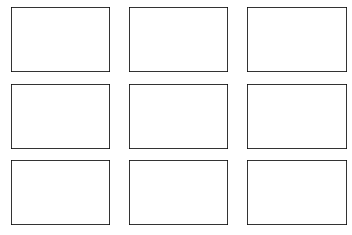

In [19]:
features_prob_dist_array = []

for o, j in images_collection.items():
    print("img:")
    contrast_features_array = []
    homogeneity_features_array = []
    dissimilarity_features_array = []
    energy_features_array = []
    correlation_features_array = []
    
    image_string = '../../../paper3/StanfordDogs/Stanford_Dogs/Images/n02089973-English_foxhound/' + j
  
    img = imread(image_string)
    img = resize(img,(224,224,3))
        # get the path of image to extract the class
    img_class =j[0]
    img = img_to_array(img)    
    # expand the image dimensions
    img = expand_dims(img, axis=0)
        # scale the pixels
    img = preprocess_input(img)
        # get the features of the first layer
    feature_maps = model.predict(img)
    
    correlation_numerator = []
    energy_numerator = []
    homogeneity_numerator = []
    dissimilarity_numerator = []
    contrast_numerator = []
    
    ix = 1
    square = 3

    for _ in range(square):
        for _ in range(square):
            ax = pyplot.subplot(square, square, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            ##################FLATTEN THE FEATURE for dimensionality reduction##################################
            feature_items = array(feature_maps[0, :, :, ix - 1])
            #get the unsigned values of the feature
            features_x = feature_items.astype(np.uint8)        
            #get the grey-level cooccurrence matrix
            graycom = feature.greycomatrix(features_x, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], levels=256)            
            # Find the GLCM properties
            correlation = feature.greycoprops(graycom, 'correlation') 
            contrast = feature.greycoprops(graycom, 'contrast')
            dissimilarity = feature.greycoprops(graycom, 'dissimilarity')
            homogeneity = feature.greycoprops(graycom, 'homogeneity')
            energy = feature.greycoprops(graycom, 'energy')
            correlation = feature.greycoprops(graycom, 'correlation') 
            
            #get the probability distribution using correlation harrick features except correlation
            contrast_prob = softMax(0.5,contrast[0])
            dissimilarity_prob = softMax(0.5,dissimilarity[0])
            homogeneity_prob = softMax(0.5,homogeneity[0])
            energy_prob = softMax(0.5,energy[0])
            correlation_prob = softMax(0.5,correlation[0])
            
            #get the conflated distribution for this feature
            conf_numerator_contrast = np.prod(contrast_prob)
            conf_numerator_dissimilarity = np.prod(correlation_prob)
            conf_numerator_homogeneity = np.prod(homogeneity_prob)
            conf_numerator_energy = np.prod(energy_prob)
            conf_numerator_correlation = np.prod(correlation_prob)
            
            contrast_numerator.append(conf_numerator_contrast)
            energy_numerator.append(conf_numerator_energy)
            dissimilarity_numerator.append(conf_numerator_dissimilarity)
            homogeneity_numerator.append(conf_numerator_homogeneity)
            correlation_numerator.append(conf_numerator_correlation)
            
            #image_features_array.append(correlation_prob)
            contrast_features_array.append(contrast_numerator)
            homogeneity_features_array.append(homogeneity_numerator)
            dissimilarity_features_array.append(dissimilarity_numerator)
            energy_features_array.append(energy_numerator)
            correlation_features_array.append(correlation_numerator)
            #pyplot.imshow(feature_maps[0, :, :, ix - 1], cmap='gray')
            
            ix += 1
    correlation_denominator = np.trapz(correlation_numerator,axis=0)
    contrast_denominator = np.trapz(contrast_numerator,axis=0)
    homogeneity_denominator = np.trapz(homogeneity_numerator,axis=0)
    dissimilarity_denominator = np.trapz(dissimilarity_numerator,axis=0)
    energy_denominator = np.trapz(energy_numerator,axis=0)
    
    #conflated distribution for the image becomes
    conflated_dist_correlation = correlation_numerator/correlation_denominator
    conflated_dist_contrast = contrast_numerator/contrast_denominator
    conflated_dist_homogeneity = homogeneity_numerator/homogeneity_denominator
    conflated_dist_dissimilarity = dissimilarity_numerator/dissimilarity_denominator
    conflated_dist_energy = energy_numerator/energy_denominator
    
    new_rec_corr = {j + "_/" +'n02089973-English_foxhound': conflated_dist_correlation.tolist()}
    new_rec_cont = {j + "_/" +'n02089973-English_foxhound': conflated_dist_contrast.tolist()}
    new_rec_homo = {j + "_/" +'n02089973-English_foxhound': conflated_dist_homogeneity.tolist()}
    new_rec_diss = {j + "_/" +'n02089973-English_foxhound': conflated_dist_dissimilarity.tolist()}
    new_rec_ener = {j + "_/" +'n02089973-English_foxhound': conflated_dist_energy.tolist()}
        
    with open("InceptionV3/glcm/stanford_domain_data_new_correlation_glcm.json", 'r+') as file:
        # First we load existing data into a dict.
        file_data = json.load(file)
        # Join new_data with file_data inside emp_details
        file_data["target_images"].append(new_rec_corr)
        # Sets file's current position at offset.
        file.seek(0)
        # convert back to json.
        json.dump(file_data, file, indent=4)
    
    with open("InceptionV3/glcm/stanford_domain_data_new_contrast_glcm.json", 'r+') as file:
        # First we load existing data into a dict.
        file_data = json.load(file)
        # Join new_data with file_data inside emp_details
        file_data["target_images"].append(new_rec_cont)
        # Sets file's current position at offset.
        file.seek(0)
        # convert back to json.
        json.dump(file_data, file, indent=4)
    
    with open("InceptionV3/glcm/stanford_domain_data_new_homogeneity_glcm.json", 'r+') as file:
        # First we load existing data into a dict.
        file_data = json.load(file)
        # Join new_data with file_data inside emp_details
        file_data["target_images"].append(new_rec_homo)
        # Sets file's current position at offset.
        file.seek(0)
        # convert back to json.
        json.dump(file_data, file, indent=4)
        
    with open("InceptionV3/glcm/stanford_domain_data_new_dissimilarity_glcm.json", 'r+') as file:
        # First we load existing data into a dict.
        file_data = json.load(file)
        # Join new_data with file_data inside emp_details
        file_data["target_images"].append(new_rec_diss)
        # Sets file's current position at offset.
        file.seek(0)
        # convert back to json.
        json.dump(file_data, file, indent=4)
        
    with open("InceptionV3/glcm/stanford_domain_data_new_energy_glcm.json", 'r+') as file:
        # First we load existing data into a dict.
        file_data = json.load(file)
        # Join new_data with file_data inside emp_details
        file_data["target_images"].append(new_rec_ener)
        # Sets file's current position at offset.
        file.seek(0)
        # convert back to json.
        json.dump(file_data, file, indent=4)

    ##if they need to be saved in a bigger file
    #features_prob_dist_array.append(conflated_dist)